In [35]:
import glob
import os

import nibabel as nib
import numpy as np
import torch
from torch.utils.data import DataLoader

import medtool.data.feta_dataset as feta_dataset

inputDir = "../../feta_2.0/sub-001/" #"/input"
outputDir = "../medtool/output/" #"/output"

model = torch.load("../models/unetpp_se_resnext50_32x4d_balanced.pt")
model.to("cuda")
model.eval()

T2wImagePath = glob.glob(os.path.join(inputDir, "anat", "sub-*_T2w.nii.gz"))[0]
nifty_image = nib.load(T2wImagePath)
sub = os.path.split(T2wImagePath)[1].split("_")[0]

In [36]:
images = np.array(
    np.moveaxis(np.asarray(nifty_image.dataobj), -1, 0)
).reshape(-1, 256, 256)

In [37]:
test_dataset = feta_dataset.FeTA(
    images
)

test_loader = DataLoader(
    test_dataset,
    batch_size=1,
    shuffle=False,
    num_workers=4,
    drop_last=False,
)

In [38]:
def get_mask(img):
    summed_up_masks = np.zeros((256, 256))
    for ind, i in enumerate(img):
        inversed_summed_up = ~ ((summed_up_masks).astype(bool))
        summed_up_masks += (i > 0.4) * inversed_summed_up * (ind + 1)

    return summed_up_masks

In [39]:
result = []
for one_slice in test_loader:
    one_slice = one_slice.to('cuda')
    output = model(one_slice)[0]
    
    stacked_mask = get_mask(output.detach().cpu().numpy())
    result.append(stacked_mask)
    
result = np.moveaxis(np.array(result), 0, -1)

In [40]:
nib.save(nib.Nifti1Image(result, nifty_image.affine, nifty_image.header), os.path.join(outputDir, sub + '_seg_result.nii.gz'))

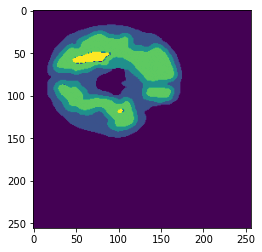

In [7]:
plt.imshow(result[70])

In [41]:
import json
import sys

import numpy as np
import nibabel as nib
import albumentations as A
import segmentation_models_pytorch as smp
import torch
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

import medtool.data.feta_dataset as feta_dataset
import segmentation_models_pytorch as smp

with open('../configs/tissue_annotation.json', 'r') as f:
    config = json.load(f)

In [42]:
import cv2

In [98]:
model = torch.load('../models/unetpp_se_resnext50_32x4d_balanced.pt')

In [99]:
model.to('cuda')
model.eval();

In [71]:
transform = A.Compose([
#     A.CropNonEmptyMaskIfExists(height=128, width=128, p=0.2),
#     A.OneOf([
#         A.HorizontalFlip(p=0.5),
#         A.VerticalFlip(p=0.5),
#         A.RandomRotate90(p=0.5),
#     ], p=0.5),
#     # A.OneOf([
#     #     A.MotionBlur(p=0.05),
#     A.MedianBlur(blur_limit=3, p=0.01),
#     #     A.Blur(blur_limit=3, p=0.05),
#     # ], p=0.02),
#     A.ShiftScaleRotate(shift_limit=0.0625, scale_limit=0.2, rotate_limit=45, p=0.05),
#     A.CoarseDropout(p=0.05),
    A.Resize(height=256, width=256, always_apply=True, p=1)
], p=0.8)

In [43]:
data, labels = feta_dataset.get_path('../' + config['data_path'])

train_data, valid_data     = data[:65], data[65:]
train_labels, valid_labels = labels[:65], labels[65:]

In [44]:
tmp = np.array([np.moveaxis(((np.asarray(nib.load(i).dataobj) / 8).astype('uint8')), -1, 0) for i in train_data])

In [45]:
np.random.rand()

0.6457338238336466

In [46]:
tmp.reshape(-1, 256, 256)[50].sum()

852437

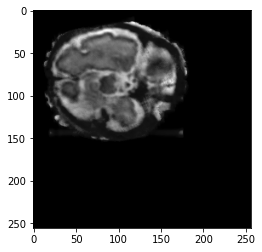

In [47]:
plt.imshow(tmp.reshape(-1, 256, 256)[60], cmap='gray')

In [100]:
#############INFERENCE###############3

In [110]:
img_num = 60

res = transform(
    image=tmp.reshape(-1, 256, 256)[img_num], 
    masks=[(nib.load(train_labels[0]).get_fdata()[:,:,img_num]==i).astype('uint8') for i in range(1, 8)]
)

In [111]:
model_output = model(torch.tensor([[tmp.reshape(-1, 256, 256)[img_num]]], dtype=torch.float).to('cuda'))

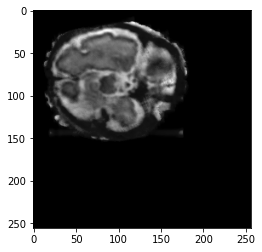

In [112]:
plt.imshow(res['image'], cmap='gray')

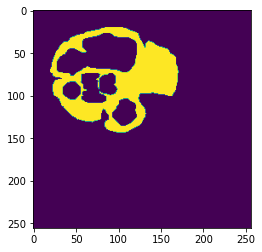

In [138]:
plt.imshow(res['masks'][0])

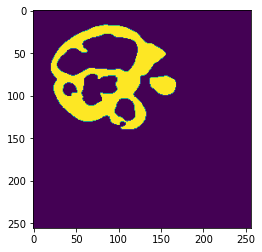

In [144]:
plt.imshow((model_output.squeeze(0)[0].detach().cpu().numpy()) > 0.4)